In [ ]:
# %pip install mapclassify

In [10]:
import geopandas as gpd
import folium
from branca.element import Template, MacroElement
import mapclassify

In [23]:
from sqlalchemy import create_engine

# DB credentials
DB_PARAMS = {
    "host": "dtim.essi.upc.edu",
    "port": 5432,
    "dbname": "dbakosschneider",
    "user": "akosschneider",
    "password": "DMT2025!"
}

def get_engine():
    return create_engine(
        f"postgresql+psycopg2://{DB_PARAMS['user']}:{DB_PARAMS['password']}"
        f"@{DB_PARAMS['host']}:{DB_PARAMS['port']}/{DB_PARAMS['dbname']}"
    )

engine = get_engine()
print("✅ Connected to database")


✅ Connected to database


# Coverage

## District level

In [16]:
# Prepare the query
query = """
SELECT
    l.district_name,
    t.year,
    AVG(m.coverage_score)              AS avg_coverage_score,
    d.geometry               AS geometry        
FROM fact_bike_tract_metrics AS m
JOIN dim_location         AS l ON m.census_tract_id = l.census_tract_id
JOIN districts_clean AS d ON l.district_name = d.nom
JOIN dim_trimester        AS t ON m.year_trimester  = t.year_trimester
GROUP BY
    l.district_name,
    t.year,
    d.geometry;

"""

district_coverage_gdf = gpd.read_postgis(query, engine, geom_col="geometry")

In [4]:
district_coverage_gdf.head()

district_name  year  avg_coverage_score  \
0  Ciutat Vella  2019            0.135528   
1  Ciutat Vella  2020            0.131581   
2  Ciutat Vella  2021            0.118135   
3      Eixample  2019            0.305291   
4      Eixample  2020            0.327420   

                                            geometry  
0  MULTIPOLYGON (((2.1714 41.37731, 2.17164 41.37...  
1  POLYGON ((2.1714 41.37731, 2.17164 41.37719, 2...  
2  POLYGON ((2.1714 41.37731, 2.17164 41.37719, 2...  
3  POLYGON ((2.14593 41.37797, 2.14714 41.37884, ...  
4  POLYGON ((2.14231 41.38084, 2.14242 41.3824, 2...

In [45]:
district_coverage_gdf.explore()

### Choropleth Map

In [46]:
import folium
from folium.elements import MacroElement
from jinja2 import Template
import branca.colormap as cm
import geopandas as gpd           

# ────────────────────────────────────────────────────────────────
# 0.  Choose which year you want on the map
# ────────────────────────────────────────────────────────────────
YEAR_TO_SHOW = 2021               # ← change this if needed

# ────────────────────────────────────────────────────────────────
# 1.  Prepare the GeoDataFrame (WGS-84, one row per neighbourhood)
# ────────────────────────────────────────────────────────────────
gdf: gpd.GeoDataFrame = (
    district_coverage_gdf
    .query("year == @YEAR_TO_SHOW")        # keep just one year
    .to_crs(epsg=4326)
    .copy()
)

# unique key for folium.Choropleth
gdf["district_id"] = gdf["district_name"].str.replace("'", r"\'")

# nice-looking tooltip value
gdf["score_fmt"] = gdf["avg_coverage_score"].round(3)

# ────────────────────────────────────────────────────────────────
# 2.  Colour scale (shared across the selected year)
# ────────────────────────────────────────────────────────────────
vmin, vmax = gdf["avg_coverage_score"].min(), gdf["avg_coverage_score"].max()
cmap = cm.linear.YlOrRd_09.scale(vmin, vmax)

# ────────────────────────────────────────────────────────────────
# 3.  Base map
# ────────────────────────────────────────────────────────────────
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

m = folium.Map(location=[center_lat, center_lon],
               tiles=None,
               zoom_start=11)

# dark basemap (CartoDB DarkMatter)
folium.TileLayer(
    tiles="https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png",
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a>'
         ' &copy; <a href="https://carto.com/attributions">CARTO</a>',
    name="CartoDB DarkMatter",
    subdomains="abcd",
    max_zoom=20
).add_to(m)

# remove focus outline (CSS macro)
css_macro = MacroElement()
css_macro._template = Template("""
{% macro html(this, kwargs) %}
<style>
  path.leaflet-interactive:focus { outline: none; }
</style>
{% endmacro %}
""")
css_macro.add_to(m)

# ────────────────────────────────────────────────────────────────
# 4.  Choropleth layer (no time slider, just one snapshot)
# ────────────────────────────────────────────────────────────────
choropleth = folium.Choropleth(
    geo_data=gdf.__geo_interface__,
    name=f"Coverage {YEAR_TO_SHOW}",
    data=gdf,
    columns=["district_id", "avg_coverage_score"],
    key_on="feature.properties.district_id",
    fill_color="YlOrRd",
    fill_opacity=0.9,
    line_opacity=0.4,
    nan_fill_color="lightgrey",
    bins=5,
    legend_name=f"Avg. bike-lane coverage ({YEAR_TO_SHOW})"
).add_to(m)

# tooltip
folium.GeoJsonTooltip(
    fields=["district_name", "score_fmt"],
    aliases=["District:", "Avg. coverage:"],
    localize=True,
).add_to(choropleth.geojson)

# ────────────────────────────────────────────────────────────────
# 5.  (Optional) custom legend CSS – reuse your previous macro
# ────────────────────────────────────────────────────────────────
legend_macro = MacroElement()
legend_macro._template = Template("""
{% macro html(this, kwargs) %}
<style>
  .legend{position:fixed;top:10px;right:20px;background:rgba(255,255,255,.9);
          border:1px solid #ccc;border-radius:5px;padding:10px;font-size:12px;
          color:#333;box-shadow:0 2px 6px rgba(0,0,0,.2);z-index:9999;}
  .legend-title{font-size:16px;font-weight:bold;color:#2c3e50;margin-bottom:6px;}
  .legend-scale ul{list-style:none;margin:0;padding:0;}
  .legend-scale ul li{display:block;margin-bottom:4px;}
  .legend-scale ul li span{display:inline-block;height:15px;width:15px;margin-right:6px;border-radius:3px;}
</style>
{% endmacro %}
""")
legend_macro.add_to(m)

# ────────────────────────────────────────────────────────────────
# 6.  Layer control + save
# ────────────────────────────────────────────────────────────────
folium.LayerControl(position="topleft").add_to(m)
m.save(f"district_coverage_choropleth_{YEAR_TO_SHOW}.html")

C:\Users\andre\AppData\Local\Temp\ipykernel_15148\1938701073.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = gdf.geometry.centroid.y.mean()
C:\Users\andre\AppData\Local\Temp\ipykernel_15148\1938701073.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = gdf.geometry.centroid.x.mean()


## Neighbourhood level

In [49]:
# Prepare the query
query = """
/* ---------------------------------------------------------------
   1.  One row per neighbourhood + year with the score, 
       missing rows are allowed
   ---------------------------------------------------------------*/
WITH metrics AS (
    SELECT
        l.neighbourhood_name,
        t.year,
        AVG(m.coverage_score) AS avg_coverage_score
    FROM fact_bike_tract_metrics   AS m
    JOIN dim_location        AS l  ON l.census_tract_id = m.census_tract_id
    JOIN dim_trimester       AS t  ON t.year_trimester   = m.year_trimester
    GROUP BY l.neighbourhood_name, t.year
)

/* ---------------------------------------------------------------
   2.  Cross-join *every* neighbourhood with *every* year that
       exists in dim_trimester, then left-join the metrics
   ---------------------------------------------------------------*/
SELECT
    n.nom                     AS neighbourhood_name,
    y.year,
    COALESCE(mt.avg_coverage_score, 0) AS avg_coverage_score,  -- ⇦ fill gaps with 0
    n.geometry
FROM neighbourhoods_clean      AS n                           -- all polygons
CROSS JOIN (SELECT DISTINCT year FROM dim_trimester) AS y     -- all calendar years
LEFT  JOIN metrics            AS mt
       ON  mt.neighbourhood_name = n.nom
       AND mt.year              = y.year
ORDER BY n.nom, y.year;         -- optional


"""

neigh_coverage_gdf = gpd.read_postgis(query, engine, geom_col="geometry")

In [50]:
neigh_coverage_gdf.explore()

In [20]:
# Prepare the query
query = """
SELECT *      
FROM neighbourhoods_clean;

"""

neigh_geom_gdf = gpd.read_postgis(query, engine, geom_col="geometry")

In [29]:
neigh_geom_gdf.explore()

### Choropleth Map

In [51]:
import folium
from folium.elements import MacroElement
from jinja2 import Template
import branca.colormap as cm
import json
import geopandas as gpd            # only here to stress the type

# ────────────────────────────────────────────────────────────────
# 0.  Choose which year you want on the map
# ────────────────────────────────────────────────────────────────
YEAR_TO_SHOW = 2021               # ← change this if needed

# ────────────────────────────────────────────────────────────────
# 1.  Prepare the GeoDataFrame (WGS-84, one row per neighbourhood)
# ────────────────────────────────────────────────────────────────
gdf: gpd.GeoDataFrame = (
    neigh_coverage_gdf
    .query("year == @YEAR_TO_SHOW")        # keep just one year
    .to_crs(epsg=4326)
    .copy()
)

# unique key for folium.Choropleth
gdf["neigh_id"] = gdf["neighbourhood_name"].str.replace("'", r"\'")

# nice-looking tooltip value
gdf["score_fmt"] = gdf["avg_coverage_score"].round(3)

# ────────────────────────────────────────────────────────────────
# 2.  Colour scale (shared across the selected year)
# ────────────────────────────────────────────────────────────────
vmin, vmax = gdf["avg_coverage_score"].min(), gdf["avg_coverage_score"].max()
cmap = cm.linear.YlOrRd_09.scale(vmin, vmax)

# ────────────────────────────────────────────────────────────────
# 3.  Base map
# ────────────────────────────────────────────────────────────────
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

m = folium.Map(location=[center_lat, center_lon],
               tiles=None,
               zoom_start=11)

# dark basemap (CartoDB DarkMatter)
folium.TileLayer(
    tiles="https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png",
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a>'
         ' &copy; <a href="https://carto.com/attributions">CARTO</a>',
    name="CartoDB DarkMatter",
    subdomains="abcd",
    max_zoom=20
).add_to(m)

# remove focus outline (CSS macro)
css_macro = MacroElement()
css_macro._template = Template("""
{% macro html(this, kwargs) %}
<style>
  path.leaflet-interactive:focus { outline: none; }
</style>
{% endmacro %}
""")
css_macro.add_to(m)

# ────────────────────────────────────────────────────────────────
# 4.  Choropleth layer (no time slider, just one snapshot)
# ────────────────────────────────────────────────────────────────
choropleth = folium.Choropleth(
    geo_data=gdf.__geo_interface__,
    name=f"Coverage {YEAR_TO_SHOW}",
    data=gdf,
    columns=["neigh_id", "avg_coverage_score"],
    key_on="feature.properties.neigh_id",
    fill_color="YlOrRd",
    fill_opacity=0.9,
    line_opacity=0.4,
    nan_fill_color="lightgrey",
    bins=5,
    legend_name=f"Avg. bike-lane coverage ({YEAR_TO_SHOW})"
).add_to(m)

# tooltip
folium.GeoJsonTooltip(
    fields=["neighbourhood_name", "score_fmt"],
    aliases=["Neighbourhood:", "Avg. coverage:"],
    localize=True,
).add_to(choropleth.geojson)

# ────────────────────────────────────────────────────────────────
# 5.  (Optional) custom legend CSS – reuse your previous macro
# ────────────────────────────────────────────────────────────────
legend_macro = MacroElement()
legend_macro._template = Template("""
{% macro html(this, kwargs) %}
<style>
  .legend{position:fixed;top:10px;right:20px;background:rgba(255,255,255,.9);
          border:1px solid #ccc;border-radius:5px;padding:10px;font-size:12px;
          color:#333;box-shadow:0 2px 6px rgba(0,0,0,.2);z-index:9999;}
  .legend-title{font-size:16px;font-weight:bold;color:#2c3e50;margin-bottom:6px;}
  .legend-scale ul{list-style:none;margin:0;padding:0;}
  .legend-scale ul li{display:block;margin-bottom:4px;}
  .legend-scale ul li span{display:inline-block;height:15px;width:15px;margin-right:6px;border-radius:3px;}
</style>
{% endmacro %}
""")
legend_macro.add_to(m)

# ────────────────────────────────────────────────────────────────
# 6.  Layer control + save
# ────────────────────────────────────────────────────────────────
folium.LayerControl(position="topleft").add_to(m)
m.save(f"neigh_coverage_choropleth_{YEAR_TO_SHOW}.html")


C:\Users\andre\AppData\Local\Temp\ipykernel_15148\3806032881.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = gdf.geometry.centroid.y.mean()
C:\Users\andre\AppData\Local\Temp\ipykernel_15148\3806032881.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = gdf.geometry.centroid.x.mean()


# Correlations

In [ ]:
%pip install statsmodels

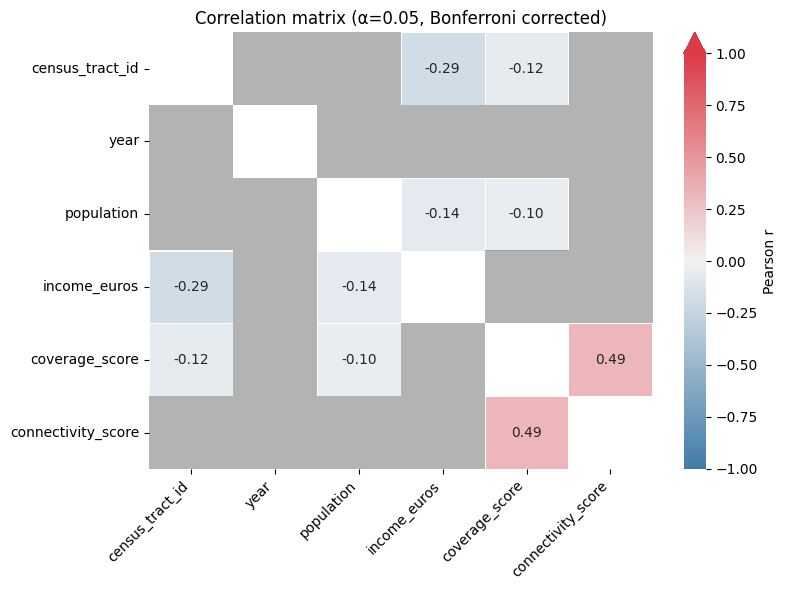

In [30]:
# ────────────────────────────────
# 0.  Imports & DB connection
# ────────────────────────────────
import pandas as pd
import numpy as np
import sqlalchemy as sa
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns


# ────────────────────────────────
# 1.  One SQL query (JOIN + filter)
# ────────────────────────────────
sql = """
/* ---------- STEP 1:  compute year-level bike metrics ---------- */
WITH bike_year AS (
    SELECT
        census_tract_id,
        CAST(LEFT(year_trimester, 4) AS INTEGER)              AS year,   --  “2020Q1” → 2020
        AVG(coverage_score)     AS avg_coverage_score,
        AVG(connectivity_score) AS avg_connectivity_score
    FROM fact_bike_tract_metrics
    GROUP BY census_tract_id, CAST(LEFT(year_trimester, 4) AS INTEGER)
)

/* ---------- STEP 2:  join to the population-income table ------ */
SELECT
    p.census_tract_id,
    p.year,
    p.population,
    p.income_euros,
    by.avg_coverage_score      AS coverage_score,
    by.avg_connectivity_score  AS connectivity_score
FROM fact_population_income  AS p
LEFT JOIN bike_year          AS by
       ON  by.census_tract_id = p.census_tract_id
       AND by.year            = p.year;          -- keeps every (tract,year) in “p”

"""
df = pd.read_sql(sql, engine)

# ────────────────────────────────
# 2.  Keep numeric cols & drop rows with any NA
# ────────────────────────────────
num = df.select_dtypes(include=[np.number]).dropna().copy()

# ────────────────────────────────
# 3.  Pair-wise Pearson r + p-values
# ────────────────────────────────
cols = num.columns
k = len(cols)
r_mat  = np.zeros((k, k))
p_mat  = np.zeros((k, k))

for i in range(k):
    for j in range(k):
        if i == j:
            r_mat[i, j] = 1
            p_mat[i, j] = 0
        else:
            r, p = stats.pearsonr(num[cols[i]], num[cols[j]])
            r_mat[i, j] = r
            p_mat[i, j] = p

# ────────────────────────────────
# 4.  Bonferroni correction
#     m = k*(k-1)/2 unique pairs
# ────────────────────────────────
tri_p = p_mat[np.triu_indices(k, 1)]
_, p_adj, _, _ = multipletests(tri_p, method="bonferroni")
p_adj_mat = np.zeros_like(p_mat)
p_adj_mat[np.triu_indices(k, 1)] = p_adj
p_adj_mat += p_adj_mat.T                 # mirror to lower triangle

alpha = 0.05
sig_mask = p_adj_mat < alpha             # True = significant

# ────────────────────────────────
# 5.  Build a masked array: non-sig → np.nan
# ────────────────────────────────
plot_data = np.where(sig_mask, r_mat, np.nan)

# ────────────────────────────────
# 6.  Plot
# ────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

# colour map: Reds/Blues centred at 0; grey for nan
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(
    plot_data,
    annot=True, fmt=".2f", linewidths=.5, cmap=cmap,
    vmin=-1, vmax=1, center=0,
    cbar_kws={"label": "Pearson r", "extend": "max"},
    mask=np.eye(k)  # hide diagonal text background
)

# add light grey overlay for non-significant cells
ax.imshow(~sig_mask, cmap="Greys", alpha=0.3,
          extent=ax.get_xlim()+ax.get_ylim(),
          aspect="auto", zorder=2)

ax.set_xticklabels(cols, rotation=45, ha="right")
ax.set_yticklabels(cols, rotation=0)
ax.set_title(f"Correlation matrix (α={alpha:.2g}, Bonferroni corrected)")
plt.tight_layout()
plt.show()

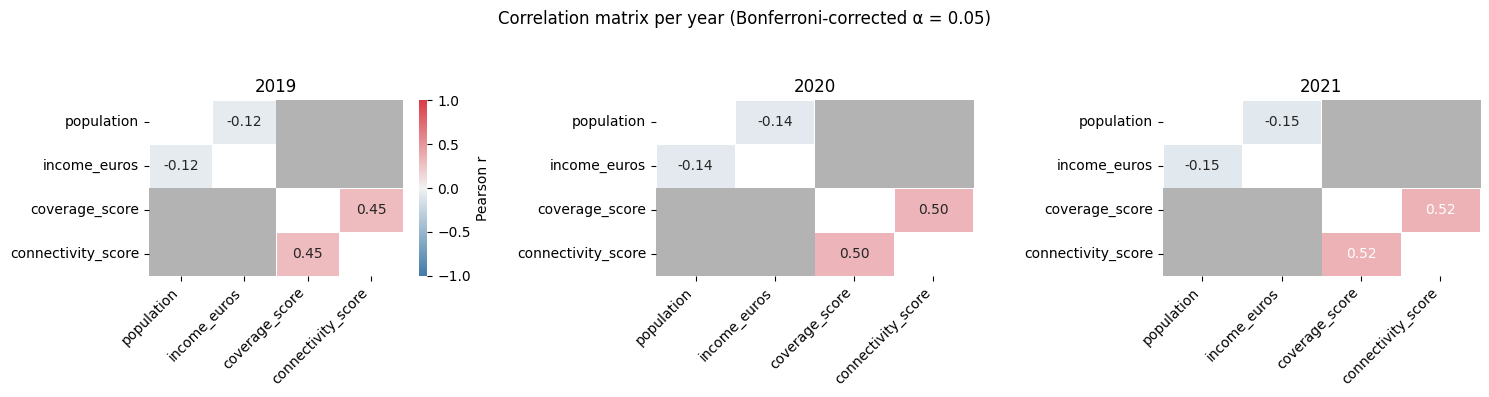

In [ ]:
# ────────────────────────────────
# 0.  Imports & DB connection
# ────────────────────────────────
import pandas as pd
import numpy as np
import sqlalchemy as sa
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns


# ────────────────────────────────
# 1.  One SQL query (JOIN + filter)
# ────────────────────────────────
sql = """
/* ---------- STEP 1:  compute year-level bike metrics ---------- */
WITH bike_year AS (
    SELECT
        census_tract_id,
        CAST(LEFT(year_trimester, 4) AS INTEGER)              AS year,   --  “2020Q1” → 2020
        AVG(coverage_score)     AS avg_coverage_score,
        AVG(connectivity_score) AS avg_connectivity_score
    FROM fact_bike_tract_metrics
    GROUP BY census_tract_id, CAST(LEFT(year_trimester, 4) AS INTEGER)
)

/* ---------- STEP 2:  join to the population-income table ------ */
SELECT
    p.census_tract_id,
    p.year,
    p.population,
    p.income_euros,
    by.avg_coverage_score      AS coverage_score,
    by.avg_connectivity_score  AS connectivity_score
FROM fact_population_income  AS p
LEFT JOIN bike_year          AS by
       ON  by.census_tract_id = p.census_tract_id
       AND by.year            = p.year;          -- keeps every (tract,year) in “p”

"""
df = pd.read_sql(sql, engine)

# ---------------------------------------------------------------
# 2.  Keep the four numeric variables of interest
# ---------------------------------------------------------------
NUM_VARS = ["population", "income_euros", "coverage_score", "connectivity_score"]

df_years = (
    df[["year", *NUM_VARS]]  # keep year + 4 cols
    .dropna()  # required by Pearson r
    .astype({"year": int})  # year is the grouper
)


# ---------------------------------------------------------------
# helper that returns (masked_r , sig_mask)
# ---------------------------------------------------------------
def corr_with_sig(block, alpha=0.05):
    cols = block.columns
    k = len(cols)

    r_mat = np.eye(k)
    p_mat = np.zeros((k, k))

    # pair-wise Pearson
    for i in range(k):
        for j in range(i + 1, k):
            r, p = stats.pearsonr(block.iloc[:, i], block.iloc[:, j])
            r_mat[i, j] = r_mat[j, i] = r
            p_mat[i, j] = p_mat[j, i] = p

    # Bonferroni correction on upper-tri p values
    tri_p = p_mat[np.triu_indices(k, 1)]
    _, p_adj, _, _ = multipletests(tri_p, method="bonferroni")
    p_adj_mat = np.zeros_like(p_mat)
    p_adj_mat[np.triu_indices(k, 1)] = p_adj
    p_adj_mat += p_adj_mat.T

    sig_mask = p_adj_mat < alpha  # True → significant
    masked_r = np.where(sig_mask, r_mat, np.nan)
    return masked_r, sig_mask, cols


# ---------------------------------------------------------------
# 3-6.  Loop over years and plot
# ---------------------------------------------------------------
unique_years = sorted(df_years["year"].unique())
n_years = len(unique_years)

fig, axes = plt.subplots(
    nrows=1, ncols=n_years, figsize=(5 * n_years, 4), squeeze=False  # axes is 2-D
)

cmap = sns.diverging_palette(240, 10, as_cmap=True)

for ax, yr in zip(axes[0], unique_years):
    block = df_years.loc[df_years["year"] == yr, NUM_VARS]

    if len(block) < 3:
        ax.set_title(f"{yr} (too few rows)")
        ax.axis("off")
        continue

    masked_r, sig_mask, cols = corr_with_sig(block)

    sns.heatmap(
        masked_r,
        ax=ax,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        center=0,
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        cbar=(ax is axes[0, 0]),
        cbar_kws={"label": "Pearson r"} if ax is axes[0, 0] else None,
        mask=np.eye(len(cols)),
    )

    # grey overlay for non-sig cells
    ax.imshow(
        ~sig_mask,
        cmap="Greys",
        alpha=0.3,
        extent=ax.get_xlim() + ax.get_ylim(),
        aspect="auto",
        zorder=2,
    )

    ax.set_xticklabels(cols, rotation=45, ha="right")
    ax.set_yticklabels(cols, rotation=0)
    ax.set_title(f"{yr}")

plt.suptitle("Correlation matrix per year (Bonferroni-corrected α = 0.05)")
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()